### Data Modeling

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [2]:
# Load the data
df = pd.read_csv('FULL_RAW_ML_READY.csv')
df.head()

,index,Birth_Sex,Age,Race,State,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,...,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Metropolitan_y_n,Urban_Rural,Reported_Income,Education_Level,Avg_Hours_of_Sleep
0,0,2,8,1.0,1,1,2,1.0,1.0,3,...,2.0,2.0,1.0,2.0,1,1.0,1.0,1,4,5.0
1,1,2,10,2.0,1,1,1,3.0,3.0,1,...,2.0,2.0,NaN,2.0,1,1.0,1.0,9,4,7.0
2,2,2,10,2.0,1,1,1,NaN,3.0,1,...,2.0,2.0,1.0,2.0,1,1.0,1.0,5,3,7.0
3,3,2,13,1.0,1,1,1,NaN,3.0,1,...,2.0,2.0,NaN,2.0,2,1.0,1.0,9,2,6.0
4,4,2,13,1.0,1,1,1,2.0,3.0,1,...,2.0,1.0,NaN,2.0,1,1.0,1.0,9,4,7.0


We will delete the following as those need not be used in Machine Learning and can be used in Visualizations
Metropolitan_y_n, 
Urban_Rural, 
Reported_Income, 
Education_Level

In [3]:
#Removing the columns State, index, Metropolitan_y_n, Urban_Rural, Reported_Income, Education_Level as its not needed for Machine Learning and can be utilized for visualizations
df = df.drop(["index","State","Metropolitan_y_n","Urban_Rural","Reported_Income","Education_Level"], axis=1)
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,2,8,1.0,1,2,1.0,1.0,3,1,2,2,2.0,2.0,1.0,2.0,1,5.0
1,2,10,2.0,1,1,3.0,3.0,1,9,9,2,2.0,2.0,NaN,2.0,1,7.0
2,2,10,2.0,1,1,NaN,3.0,1,1,1,1,2.0,2.0,1.0,2.0,1,7.0
3,2,13,1.0,1,1,NaN,3.0,1,1,1,1,2.0,2.0,NaN,2.0,2,6.0
4,2,13,1.0,1,1,2.0,3.0,1,1,1,1,2.0,1.0,NaN,2.0,1,7.0


From CDC website, we know for PHYSICAL_HEALTH we have 
when "Physical_Health"=1 then it means Zero days when physical health not good
when "Physical_Health"=2 then it means 1-13 days when physical health not good
when "Physical_Health"=3 then it means 14+ days when physical health not good
when "Physical_Health"=9 then it means Don’t know/ Refused/ Missing

In [4]:
df["Physical_Health"].value_counts()

1    278671
2     71588
3     43008
9      8691
Name: Physical_Health, dtype: int64

In [5]:
# Split Colonscopy NaNs into 3 bunches proportinately and update them with 1, 2, 3 to insert no bias to the model
idx = df['Physical_Health'].index[df['Physical_Health']==9]
df4 = df[df['Physical_Health'] != 9]
x = df4['Physical_Health'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)


second_update = sample1_perct + sample2_perct


df.loc[idx[0:sample1_perct], 'Physical_Health'] = 1
df.loc[idx[sample1_perct:second_update], 'Physical_Health'] = 2
df.loc[idx[second_update:total_len], 'Physical_Health'] = 3
# df.head(10)

8691
6158
1582
950


In [6]:
df["Physical_Health"].value_counts()

1    284829
2     73170
3     43959
Name: Physical_Health, dtype: int64

from the CDC website document about this dataset, we came to know from the SAS code that
Birth_Sex of 1 = Male and 2 = Female, we will change this to Male - 1 and Female - 0

In [7]:
#Unique values for Sex
df["Birth_Sex"].value_counts()

2    218027
1    183931
Name: Birth_Sex, dtype: int64

In [8]:
df.loc[df["Birth_Sex"] == 2, "Birth_Sex"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.0,1.0,3,1,2,2,2.0,2.0,1.0,2.0,1,5.0
1,0,10,2.0,1,1,3.0,3.0,1,9,9,2,2.0,2.0,NaN,2.0,1,7.0
2,0,10,2.0,1,1,NaN,3.0,1,1,1,1,2.0,2.0,1.0,2.0,1,7.0
3,0,13,1.0,1,1,NaN,3.0,1,1,1,1,2.0,2.0,NaN,2.0,2,6.0
4,0,13,1.0,1,1,2.0,3.0,1,1,1,1,2.0,1.0,NaN,2.0,1,7.0


As per the CDC website, the Age for this column was categorized as below
when "Age"=1 then '18-24'
when "Age"=2 then '25-29'
when "Age"=3 then '30-34'
when "Age"=4 then '35-39'
when "Age"=5 then '40-44'
when "Age"=6 then '45-49'
when "Age"=7 then '50-54'
when "Age"=8 then '55-59'
when "Age"=9 then '60-64'
when "Age"=10 then '65-69'
when "Age"=11 then '70-74'
when "Age"=12 then '75-79'
when "Age"=13 then '80-84'
when "Age"=14 then 'NaN' -- missing

In [9]:
#Unique values for Age - delete 
df["Age"].value_counts()

10    41570
9     41151
11    37972
8     36219
13    31456
7     31110
12    26607
6     26428
5     25729
1     25648
4     25492
3     23408
2     20911
14     8257
Name: Age, dtype: int64

Looks like we have Age value 14 which were rows with missing values. Instead of dropping those rows, we will try to create 13 bunches of each value and add to the respective bins.

In [10]:
# Split Age column with value 14 into 13 bunches and update them with 1, to 13 to insert no bias to the model
idx = df['Age'].index[df['Age']==14]
df4 = df[df['Age'] != 14]
x = df4['Age'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)
sample4_perct = int((total_len*x[4]/100).round(1))
print(sample4_perct)
sample5_perct = int((total_len*x[5]/100).round(1))
print(sample5_perct)
sample6_perct = int((total_len*x[6]/100).round(1))
print(sample6_perct)
sample7_perct = int((total_len*x[7]/100).round(1))
print(sample7_perct)
sample8_perct = int((total_len*x[8]/100).round(1))
print(sample8_perct)
sample9_perct = int((total_len*x[9]/100).round(1))
print(sample9_perct)
sample10_perct = int((total_len*x[10]/100).round(1))
print(sample10_perct)
sample11_perct = int((total_len*x[11]/100).round(1))
print(sample11_perct)
sample12_perct = int((total_len*x[12]/100).round(1))
print(sample12_perct)
sample13_perct = int((total_len*x[13]/100).round(1))
print(sample13_perct)


second_update = sample1_perct + sample2_perct
third_update = second_update + sample3_perct
fourth_update = third_update + sample4_perct
fifth_update = fourth_update + sample5_perct
sixth_update = fifth_update + sample6_perct
seventh_update = sixth_update + sample7_perct
eight_update = seventh_update + sample8_perct
ninth_update = eight_update + sample9_perct
tenth_update = ninth_update + sample10_perct
eleventh_update = tenth_update + sample11_perct
twelveth_update = eleventh_update + sample12_perct
thirteenth_update = twelveth_update + sample13_perct


df.loc[idx[0:sample1_perct], 'Age'] = 1
df.loc[idx[sample1_perct:second_update], 'Age'] = 2
df.loc[idx[second_update:third_update], 'Age'] = 3
df.loc[idx[third_update:fourth_update], 'Age'] = 4
df.loc[idx[fourth_update:fifth_update], 'Age'] = 5
df.loc[idx[fifth_update:sixth_update], 'Age'] = 6
df.loc[idx[sixth_update:seventh_update], 'Age'] = 7
df.loc[idx[seventh_update:eight_update], 'Age'] = 8
df.loc[idx[eight_update:ninth_update], 'Age'] = 9
df.loc[idx[ninth_update:tenth_update], 'Age'] = 10
df.loc[idx[tenth_update:eleventh_update], 'Age'] = 11
df.loc[idx[eleventh_update:twelveth_update], 'Age'] = 12
df.loc[idx[twelveth_update:total_len], 'Age'] = 13


8257
537
438
490
534
539
554
652
759
863
871
796
558
659


In [11]:
df["Age"].value_counts()

10    42441
9     42014
11    38768
8     36978
13    32122
7     31762
12    27165
6     26982
5     26268
1     26185
4     26026
3     23898
2     21349
Name: Age, dtype: int64

--We know the following RACE from CDC website SAS code
when "Race"=1 then 'White'
when "Race"=2 then 'Black'
when "Race"=3 then 'American Indian/Alaskan Native'
when "Race"=4 then 'Asian'
when "Race"=5 then 'Native Hawaiian or other Pacific Islander only, Non-Hispanic'
when "Race"=6 then 'Other Race Only, Non-Hispanic'
when "Race" = 7 then 'Multiracial, Non-Hispanic'
when "Race"=8 then 'Hispanic'
when "Race"=9 then missing values , equivalent to NaN

In [12]:
# Unique values for Race delete
df["Race"].value_counts()

1.0    295900
8.0     36322
2.0     30130
4.0     10138
9.0      8987
7.0      8314
3.0      6813
6.0      3344
5.0      2009
Name: Race, dtype: int64

As we see the dataset contains the value 9 which is equivalent to NaN, we will try to modify these 8056 Races with derived values to each of the other valid Races

In [13]:
# Split Race column with value 9 into 8 bunches and update them with 1, to 8 to insert no bias to the model

idx = df['Race'].index[df['Race']==9]
df4 = df[df['Race'] != 9]
x = df4['Race'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)
sample4_perct = int((total_len*x[4]/100).round(1))
print(sample4_perct)
sample5_perct = int((total_len*x[5]/100).round(1))
print(sample5_perct)
sample6_perct = int((total_len*x[6]/100).round(1))
print(sample6_perct)
sample7_perct = int((total_len*x[7]/100).round(1))
print(sample7_perct)
sample8_perct = int((total_len*x[8]/100).round(1))
print(sample8_perct)



second_update = sample1_perct + sample2_perct
third_update = second_update + sample3_perct
fourth_update = third_update + sample4_perct
fifth_update = fourth_update + sample5_perct
sixth_update = fifth_update + sample6_perct
seventh_update = sixth_update + sample7_perct
eight_update = seventh_update + sample8_perct




df.loc[idx[0:sample1_perct], 'Race'] = 1
df.loc[idx[sample1_perct:second_update], 'Race'] = 2
df.loc[idx[second_update:third_update], 'Race'] = 3
df.loc[idx[third_update:fourth_update], 'Race'] = 4
df.loc[idx[fourth_update:fifth_update], 'Race'] = 5
df.loc[idx[fifth_update:sixth_update], 'Race'] = 6
df.loc[idx[sixth_update:seventh_update], 'Race'] = 7
df.loc[idx[seventh_update:total_len], 'Race'] = 8


8987
6767
689
155
231
45
76
190
830


In [14]:
# Unique values for Race
df["Race"].value_counts()

1.0    302667
8.0     37156
2.0     30819
4.0     10369
7.0      8504
3.0      6968
6.0      3420
5.0      2054
Name: Race, dtype: int64

From the CDC website the SAS code for OVERALL_HEALTH says 
when "Overall_Health" = 1 then 'BETTER/GOOD'
when "Overall_Health" = 2 then 'FAIR/POOR'
when "Overall_Health"= 9 then Missing values
So basically we can change 1 and 2 to 1 and 0 and instead of dropping the 9 rows, we can divide them equally into 1 and 0


In [15]:
# Unique values for Overall Health - 
df["Overall_Health"].value_counts()

1    339301
2     61696
9       961
Name: Overall_Health, dtype: int64

In [16]:
df.loc[df["Overall_Health"] == 2, "Overall_Health"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.0,1.0,3,1,2,2,2.0,2.0,1.0,2.0,1,5.0
1,0,10,2.0,1,1,3.0,3.0,1,9,9,2,2.0,2.0,NaN,2.0,1,7.0
2,0,10,2.0,1,1,NaN,3.0,1,1,1,1,2.0,2.0,1.0,2.0,1,7.0
3,0,13,1.0,1,1,NaN,3.0,1,1,1,1,2.0,2.0,NaN,2.0,2,6.0
4,0,13,1.0,1,1,2.0,3.0,1,1,1,1,2.0,1.0,NaN,2.0,1,7.0


In [17]:
# Unique values for Overall Health
df["Overall_Health"].value_counts()

1    339301
0     61696
9       961
Name: Overall_Health, dtype: int64

In [18]:
#deleting rows with 9 as the number is less

df = df[df.Overall_Health != 9]

In [19]:
# Unique values for Overall Health
df["Overall_Health"].value_counts()

1    339301
0     61696
Name: Overall_Health, dtype: int64

BMI values can be in various number as each person's BMI will be different. 
Lets check if there are any missing ones. And if there are , let's have them filled in with the mean value of that column

In [20]:
df["BMI_CDC_Categories"].isnull().sum() 

41118

In [21]:
# get mean of values and update for rows which don't have a value
mean_bmi = df['BMI_CDC_Categories'].mean()
print('Mean of values in column BMI_CDC_Categories:')
print(mean_bmi)

Mean of values in column BMI_CDC_Categories:
2.981955046001573


In [22]:
# Replace NaNs in column BMI_CDC_Categories with the
# mean of values in the same column
df['BMI_CDC_Categories'].fillna(value=df['BMI_CDC_Categories'].mean(), inplace=True)
print('Updated Dataframe:')
df.head()

Updated Dataframe:


,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.000000,1.0,3,1,2,2,2.0,2.0,1.0,2.0,1,5.0
1,0,10,2.0,1,1,3.000000,3.0,1,9,9,2,2.0,2.0,NaN,2.0,1,7.0
2,0,10,2.0,1,1,2.981955,3.0,1,1,1,1,2.0,2.0,1.0,2.0,1,7.0
3,0,13,1.0,1,1,2.981955,3.0,1,1,1,1,2.0,2.0,NaN,2.0,2,6.0
4,0,13,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,1.0,NaN,2.0,1,7.0


From the CDC website we know that for Diabetes
when "Diabetes"=1 then 'Yes'
when "Diabetes"=2 then 'Yes, but only Gestational Diabetes'
when "Diabetes" =3 then 'No'
when "Diabetes"=4 then 'Borderline Diabetes'
when "Diabetes"=7 then 'NaN'
when "Diabetes"=9 then 'refused to answer

In [23]:
# Unique values for Diabetes
df["Diabetes"].value_counts()

3.0    336345
1.0     51923
4.0      8586
2.0      3365
7.0       481
9.0       294
Name: Diabetes, dtype: int64

So we see that there are 7 and 9 values which is equivalent to null/NaNs which we can spread them accross other values instead of deleting those rows

In [24]:
# Split Diabetes column with value 7/9 into 4 bunches proportinately and update them with 1 to 4 to insert no bias to the model

idx = df['Diabetes'].index[(df['Diabetes']==7) | (df['Diabetes']==9)]

df4 = df[(df['Diabetes'] != 9) & (df['Diabetes'] != 7)]

x = df4['Diabetes'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)
sample4_perct = int((total_len*x[4]/100).round(1))
print(sample4_perct)

second_update = sample1_perct + sample2_perct
third_update = second_update + sample3_perct
fourth_update = third_update + sample4_perct

df.loc[idx[0:sample1_perct], 'Diabetes'] = 1
df.loc[idx[sample1_perct:second_update], 'Diabetes'] = 2
df.loc[idx[second_update:third_update], 'Diabetes'] = 3
df.loc[idx[third_update:total_len], 'Diabetes'] = 4



775
100
6
651
16


In [25]:
# Unique values for Diabetes
df["Diabetes"].value_counts()

3.0    336996
1.0     52023
4.0      8604
2.0      3371
Name: Diabetes, dtype: int64

From CDC website, we know for Mental_Health we have 
when "Mental_Health"=1 then it means Zero days when physical health not good
when "Mental_Health"=2 then it means 1-13 days when physical health not good
when "Mental_Health"=3 then it means 14+ days when physical health not good
when "Mental_Health"=9 then it means Don’t know/ Refused/ Missing

In [26]:
# Unique values for Mental_Health  
df["Mental_Health"].value_counts()

1    255196
2     89879
3     48192
9      7730
Name: Mental_Health, dtype: int64

In [27]:
# Split Mental_Health 9 into 3 bunches proportinately and update them with 1, 2, 3 to insert no bias to the model

idx = df['Mental_Health'].index[df['Mental_Health']==9]
df4 = df[df['Mental_Health'] != 9]
x = df4['Mental_Health'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)


second_update = sample1_perct + sample2_perct


df.loc[idx[0:sample1_perct], 'Mental_Health'] = 1
df.loc[idx[sample1_perct:second_update], 'Mental_Health'] = 2
df.loc[idx[second_update:total_len], 'Mental_Health'] = 3


7730
5016
1766
947


In [28]:
# Unique values for Mental_Health
df["Mental_Health"].value_counts()

1    260212
2     91645
3     49140
Name: Mental_Health, dtype: int64

From the CDC website we know for Alcohol Usage
when "Alcohol_Usage" = 1 then 'NO'
when "Alcohol_Usage" = 2 then 'YES'
when "Alcohol_Usage" = 9 then 'NaN'
Lets get these values changed from 2 to 0

In [29]:
# Unique values for Alcohol_Usage 
df["Alcohol_Usage"].value_counts()

1    346564
9     30505
2     23928
Name: Alcohol_Usage, dtype: int64

In [30]:
df.loc[df["Alcohol_Usage"] == 2, "Alcohol_Usage"] = 0
df.head(10)

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.000000,1.0,3,1,2,2,2.0,2.0,1.0,2.0,1,5.0
1,0,10,2.0,1,1,3.000000,3.0,1,9,9,2,2.0,2.0,NaN,2.0,1,7.0
2,0,10,2.0,1,1,2.981955,3.0,1,1,1,1,2.0,2.0,1.0,2.0,1,7.0
3,0,13,1.0,1,1,2.981955,3.0,1,1,1,1,2.0,2.0,NaN,2.0,2,6.0
4,0,13,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,1.0,NaN,2.0,1,7.0
5,1,10,1.0,0,3,3.000000,1.0,3,1,1,2,2.0,2.0,1.0,2.0,1,8.0
6,0,12,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,2.0,1.0,2.0,2,6.0
7,0,10,2.0,0,3,3.000000,1.0,2,9,2,1,2.0,2.0,NaN,2.0,1,6.0
8,0,5,1.0,1,3,2.000000,3.0,1,1,1,1,2.0,2.0,NaN,2.0,1,8.0
9,0,12,2.0,0,2,3.000000,3.0,1,1,1,1,2.0,2.0,NaN,1.0,2,12.0


In [31]:
# Split Alcohol_Usage 9 into 2 bunches proportinately and update them with 1 or 0 to insert no bias to the model

idx = df['Alcohol_Usage'].index[df['Alcohol_Usage']==9]
df4 = df[df['Alcohol_Usage'] != 9]
x = df4['Alcohol_Usage'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Alcohol_Usage'] = 0
df.loc[idx[sample1_perct:total_len], 'Alcohol_Usage'] = 1


30505
1970
28534


In [32]:
# Unique values for Alcohol_Usage
df["Alcohol_Usage"].value_counts()

1    375099
0     25898
Name: Alcohol_Usage, dtype: int64

From the CDC website we know for Tobacco Usage
when "Tobacco_Usage" = 1 then 'NO'
when "Tobacco_Usage" = 2 then 'YES'
when "Tobacco_Usage" = 9 then 'NaN'
Lets get these values changed from 2 to 0

In [33]:
# Unique values for Tobacco_Usage 
df["Tobacco_Usage"].value_counts()

1    327719
2     52306
9     20972
Name: Tobacco_Usage, dtype: int64

In [34]:
df.loc[df["Tobacco_Usage"] == 2, "Tobacco_Usage"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.000000,1.0,3,1,0,2,2.0,2.0,1.0,2.0,1,5.0
1,0,10,2.0,1,1,3.000000,3.0,1,0,9,2,2.0,2.0,NaN,2.0,1,7.0
2,0,10,2.0,1,1,2.981955,3.0,1,1,1,1,2.0,2.0,1.0,2.0,1,7.0
3,0,13,1.0,1,1,2.981955,3.0,1,1,1,1,2.0,2.0,NaN,2.0,2,6.0
4,0,13,1.0,1,1,2.000000,3.0,1,1,1,1,2.0,1.0,NaN,2.0,1,7.0


In [35]:
# Split Tobacco_Usage 9 into 2 bunches proportinately and update them with 1 or 0 to insert no bias to the model
idx = df['Tobacco_Usage'].index[df['Tobacco_Usage']==9]
df4 = df[df['Tobacco_Usage'] != 9]
x = df4['Tobacco_Usage'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Tobacco_Usage'] = 0
df.loc[idx[sample1_perct:total_len], 'Tobacco_Usage'] = 1


20972
2886
18085


From the CDC website we know for Asthma_History
case when "Asthma_History"=1 then 'NO'
when "Asthma_History"=2 then 'YES'
when "Asthma_History"=9 then 'NaN'

In [36]:
# Unique values for Asthma_History 
df["Asthma_History"].value_counts()

1    345696
2     53972
9      1329
Name: Asthma_History, dtype: int64

In [37]:
# Deleting Asthma_History 9  
df = df[df.Asthma_History != 9]

In [38]:
# Unique values for Asthma_History
df["Asthma_History"].value_counts()

1    345696
2     53972
Name: Asthma_History, dtype: int64

We know that for Kidney_Disease
when "Kidney_Disease"=1 then 'YES'
when "Kidney_Disease"=2 then 'NO'
when "Kidney_Disease"=7 then 'NaN'
when "Kidney_Disease"=9 then Refused to answer

In [39]:
# Unique values for Kidney_Disease
df["Kidney_Disease"].value_counts()

2.0    383545
1.0     14896
7.0      1135
9.0        89
Name: Kidney_Disease, dtype: int64

In [40]:
df.loc[df["Kidney_Disease"] == 2, "Kidney_Disease"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.000000,1.0,3,1,0,2,0.0,2.0,1.0,2.0,1,5.0
1,0,10,2.0,1,1,3.000000,3.0,1,0,0,2,0.0,2.0,NaN,2.0,1,7.0
2,0,10,2.0,1,1,2.981955,3.0,1,1,1,1,0.0,2.0,1.0,2.0,1,7.0
3,0,13,1.0,1,1,2.981955,3.0,1,1,1,1,0.0,2.0,NaN,2.0,2,6.0
4,0,13,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,1.0,NaN,2.0,1,7.0


In [41]:
# Split Kidney_Disease column with value 7/9 into 2 bunches proportinately and update them with 1 or 0 to insert no bias to the model
idx = df['Kidney_Disease'].index[(df['Kidney_Disease']==9) | (df['Kidney_Disease']==7)]
df4 = df[(df['Kidney_Disease'] != 7) & (df['Kidney_Disease'] != 9)]
x = df4['Kidney_Disease'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Kidney_Disease'] = 0
df.loc[idx[sample1_perct:total_len], 'Kidney_Disease'] = 1


1224
1178
45


In [42]:
# Unique values for Kidney_Disease
df["Kidney_Disease"].value_counts()

0.0    384723
1.0     14942
Name: Kidney_Disease, dtype: int64

We know that for Stroke
when "Stroke" = 1 then 'YES'
when "Stroke" = 2 then 'NO'
when "Stroke" = 7 then 'NaN'
when "Stroke" = 9 then refused to answer
end "Stroke",

In [43]:
# Unique values for Stroke
df["Stroke"].value_counts()

2.0    383277
1.0     15531
7.0       821
9.0        39
Name: Stroke, dtype: int64

In [44]:
df.loc[df["Stroke"] == 2, "Stroke"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.000000,1.0,3,1,0,2,0.0,0.0,1.0,2.0,1,5.0
1,0,10,2.0,1,1,3.000000,3.0,1,0,0,2,0.0,0.0,NaN,2.0,1,7.0
2,0,10,2.0,1,1,2.981955,3.0,1,1,1,1,0.0,0.0,1.0,2.0,1,7.0
3,0,13,1.0,1,1,2.981955,3.0,1,1,1,1,0.0,0.0,NaN,2.0,2,6.0
4,0,13,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,1.0,NaN,2.0,1,7.0


In [45]:
# Split Stroke column with value 7/9 into 2 bunches proportinately and update them with 1 or 0 to insert no bias to the model
idx = df['Stroke'].index[(df['Stroke']==9) | (df['Stroke']==7)]
df4 = df[(df['Stroke'] != 7) & (df['Stroke'] != 9)]
x = df4['Stroke'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Stroke'] = 0
df.loc[idx[sample1_perct:total_len], 'Stroke'] = 1


860
826
33


In [46]:
# Unique values for Stroke
df["Stroke"].value_counts()

0.0    384103
1.0     15565
Name: Stroke, dtype: int64

In [47]:
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.000000,1.0,3,1,0,2,0.0,0.0,1.0,2.0,1,5.0
1,0,10,2.0,1,1,3.000000,3.0,1,0,0,2,0.0,0.0,NaN,2.0,1,7.0
2,0,10,2.0,1,1,2.981955,3.0,1,1,1,1,0.0,0.0,1.0,2.0,1,7.0
3,0,13,1.0,1,1,2.981955,3.0,1,1,1,1,0.0,0.0,NaN,2.0,2,6.0
4,0,13,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,1.0,NaN,2.0,1,7.0


We can see from above that Colonscopy column has some NaN values which we will modify to 1, 2, 3 in equal weights

In [48]:
df["Colonoscopy"].value_counts() 

1.0    120273
3.0     45847
2.0     10985
Name: Colonoscopy, dtype: int64

In [49]:
# Split Colonscopy NaNs into 3 bunches proportinately and update them with 1, 2, 3 to insert no bias to the model

# idx = df['Colonoscopy'].index[df['Colonoscopy']==9]
idx=df['Colonoscopy'].index[df['Colonoscopy'].isna()]
# df4 = df[df['Colonoscopy'] != 9]
df4 = df[~df['Colonoscopy'].isna()]
x = df4['Colonoscopy'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[1]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[2]/100).round(1)) 
print(sample2_perct)
sample3_perct = int((total_len*x[3]/100).round(1))
print(sample3_perct)


second_update = sample1_perct + sample2_perct


df.loc[idx[0:sample1_perct], 'Colonoscopy'] = 1
df.loc[idx[sample1_perct:second_update], 'Colonoscopy'] = 2
df.loc[idx[second_update:total_len], 'Colonoscopy'] = 3


222563
151143
13804
57614


In [50]:
df["Colonoscopy"].value_counts()

1.0    271416
3.0    103463
2.0     24789
Name: Colonoscopy, dtype: int64

CDC website says that for Prior Heart Disease
when "Prior_Heart_Disease" = 1 then 'Yes, Reported Heart Disease'
when "Prior_Heart_Disease" = 2 then 'No, Did Not Report Heart Disease'
So we will change 2 to 0 for no heart disease

In [51]:
df["Prior_Heart_Disease"].value_counts()

2.0    362585
1.0     33896
Name: Prior_Heart_Disease, dtype: int64

In [52]:
df.loc[df["Prior_Heart_Disease"] == 2, "Prior_Heart_Disease"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Prior_Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.000000,1.0,3,1,0,2,0.0,0.0,1.0,0.0,1,5.0
1,0,10,2.0,1,1,3.000000,3.0,1,0,0,2,0.0,0.0,1.0,0.0,1,7.0
2,0,10,2.0,1,1,2.981955,3.0,1,1,1,1,0.0,0.0,1.0,0.0,1,7.0
3,0,13,1.0,1,1,2.981955,3.0,1,1,1,1,0.0,0.0,1.0,0.0,2,6.0
4,0,13,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,1.0,1.0,0.0,1,7.0


In [53]:
df["Prior_Heart_Disease"].value_counts()

0.0    362585
1.0     33896
Name: Prior_Heart_Disease, dtype: int64

In [54]:
df = df.rename(columns={"Prior_Heart_Disease": "Heart_Disease"}, errors="raise")

We know from CDC website that for Physical Activity
when "Physical_Activity" = 1 then 'Yes, Physical Activities'
when "Physical_Activity" = 2 then 'No Physical Activities'
else 'NaN'

In [55]:
df["Physical_Activity"].value_counts()

1    304409
2     94644
9       615
Name: Physical_Activity, dtype: int64

In [56]:
df.loc[df["Physical_Activity"] == 2, "Physical_Activity"] = 0
df.head()

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
0,0,8,1.0,1,2,1.000000,1.0,3,1,0,2,0.0,0.0,1.0,0.0,1,5.0
1,0,10,2.0,1,1,3.000000,3.0,1,0,0,2,0.0,0.0,1.0,0.0,1,7.0
2,0,10,2.0,1,1,2.981955,3.0,1,1,1,1,0.0,0.0,1.0,0.0,1,7.0
3,0,13,1.0,1,1,2.981955,3.0,1,1,1,1,0.0,0.0,1.0,0.0,0,6.0
4,0,13,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,1.0,1.0,0.0,1,7.0


In [57]:
# Split Physical_Activity column with value 9 into 2 bunches proportinately and update them with 1 or 0 to insert no bias to the model

idx = df['Physical_Activity'].index[df['Physical_Activity']==9]
df4 = df[df['Physical_Activity'] != 9]
x = df4['Physical_Activity'].value_counts(normalize=True) * 100
total_len = len(idx)
print(total_len)
sample1_perct = int((total_len*x[0]/100).round(1))
print(sample1_perct) 
sample2_perct = int((total_len*x[1]/100).round(1)) 
print(sample2_perct)


df.loc[idx[0:sample1_perct], 'Physical_Activity'] = 0
df.loc[idx[sample1_perct:total_len], 'Physical_Activity'] = 1


615
145
469


In [58]:
df["Physical_Activity"].value_counts()

1    304879
0     94789
Name: Physical_Activity, dtype: int64

In [59]:
df["Avg_Hours_of_Sleep"].value_counts()

8.0     121680
7.0     118288
6.0      82195
5.0      24270
9.0      19727
10.0      9913
4.0       9884
77.0      3945
12.0      2837
3.0       2653
2.0       1089
1.0        754
11.0       584
99.0       505
14.0       308
16.0       303
15.0       255
18.0       139
13.0       138
20.0        90
24.0        53
17.0        27
22.0        13
23.0        10
19.0         6
21.0         2
Name: Avg_Hours_of_Sleep, dtype: int64

If we see from above there are rows where the number of hours of sleep is more than 24 hours. Lets have them deleted if its less

In [60]:
df[df['Avg_Hours_of_Sleep'] > 24]

,Birth_Sex,Age,Race,Overall_Health,Physical_Health,BMI_CDC_Categories,Diabetes,Mental_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Colonoscopy,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep
85,0,13,1.0,0,3,3.000000,1.0,1,1,1,2,0.0,1.0,1.0,1.0,0,77.0
89,0,13,1.0,1,1,2.000000,1.0,1,1,1,1,0.0,1.0,1.0,NaN,0,99.0
174,0,13,2.0,0,2,3.000000,3.0,3,1,1,1,0.0,0.0,1.0,0.0,0,77.0
208,1,2,1.0,1,1,2.000000,3.0,1,1,1,1,0.0,0.0,1.0,0.0,0,77.0
209,1,1,1.0,0,1,2.981955,1.0,1,0,0,1,1.0,0.0,1.0,0.0,0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401352,0,10,8.0,1,3,3.000000,3.0,3,1,1,1,0.0,0.0,3.0,0.0,0,77.0
401622,0,9,8.0,0,3,4.000000,3.0,1,1,1,2,0.0,0.0,1.0,0.0,0,77.0
401643,0,13,8.0,0,2,2.000000,4.0,3,1,1,1,0.0,0.0,3.0,1.0,0,77.0
401725,1,10,8.0,1,1,4.000000,1.0,1,0,1,1,0.0,0.0,1.0,0.0,0,77.0


In [61]:
# Deleting rows where number of hours is more than 24 
df = df[df.Avg_Hours_of_Sleep <= 24]

Lets check if all data are clean

In [62]:
df.isnull().sum()

Birth_Sex                0
Age                      0
Race                     1
Overall_Health           0
Physical_Health          0
BMI_CDC_Categories       0
Diabetes                 1
Mental_Health            0
Alcohol_Usage            0
Tobacco_Usage            0
Asthma_History           0
Kidney_Disease           1
Stroke                   0
Colonoscopy              0
Heart_Disease         3000
Physical_Activity        0
Avg_Hours_of_Sleep       0
dtype: int64

From the above we see that there are some NaN rows, we can delete them.

In [63]:
df.dropna(inplace=True)
df.isnull().sum()

Birth_Sex             0
Age                   0
Race                  0
Overall_Health        0
Physical_Health       0
BMI_CDC_Categories    0
Diabetes              0
Mental_Health         0
Alcohol_Usage         0
Tobacco_Usage         0
Asthma_History        0
Kidney_Disease        0
Stroke                0
Colonoscopy           0
Heart_Disease         0
Physical_Activity     0
Avg_Hours_of_Sleep    0
dtype: int64

Now the dataset looks clean and is ready for modelling

In [64]:
df.nunique()

Birth_Sex              2
Age                   13
Race                   8
Overall_Health         2
Physical_Health        3
BMI_CDC_Categories     5
Diabetes               4
Mental_Health          3
Alcohol_Usage          2
Tobacco_Usage          2
Asthma_History         2
Kidney_Disease         2
Stroke                 2
Colonoscopy            3
Heart_Disease          2
Physical_Activity      2
Avg_Hours_of_Sleep    24
dtype: int64

In [65]:
# categorical columns with 2 categories which already has 0 and 1 values. so no neeed to do Label encoding
cat_col = ['Birth_Sex', 'Overall_Health', 'Alcohol_Usage', 'Tobacco_Usage', 'Asthma_History', 'Kidney_Disease', 'Stroke', 'Physical_Activity']
# categorical columns with more than 2 unqiue values
encode_col = ['Age', 'Race', 'Physical_Health', 'BMI_CDC_Categories', 'Diabetes', 'Mental_Health', 'Colonoscopy']

df[encode_col].nunique()

Age                   13
Race                   8
Physical_Health        3
BMI_CDC_Categories     5
Diabetes               4
Mental_Health          3
Colonoscopy            3
dtype: int64

In [66]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(df[encode_col]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(encode_col)
encode_df.head()


C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6,Age_7,Age_8,Age_9,Age_10,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [67]:
# Merge one-hot encoded features and drop the originals
df = df.merge(encode_df,left_index=True, right_index=True)
df = df.drop(encode_col,1)
df.head()

C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Birth_Sex,Overall_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
0,0,1,1,0,2,0.0,0.0,0.0,1,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,1,0,0,2,0.0,0.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1,1,1,1,0.0,0.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,1,1,1,1,0.0,0.0,0.0,0,6.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,1,1,0.0,1.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [68]:
df2 = df.copy()
df2.head()

,Birth_Sex,Overall_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
0,0,1,1,0,2,0.0,0.0,0.0,1,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,1,0,0,2,0.0,0.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1,1,1,1,0.0,0.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,1,1,1,1,0.0,0.0,0.0,0,6.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,1,1,0.0,1.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [69]:
y = df2["Heart_Disease"]
X = df2.drop(columns="Heart_Disease")

In [70]:
from sklearn.model_selection import train_test_split
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)
Counter(y_train)

Counter({0.0: 262579, 1.0: 24391})

0.0    350105
1.0     32522
Name: Heart_Disease, dtype: int64

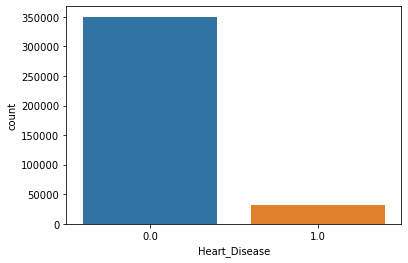

In [71]:
import seaborn as sns
sns.countplot(x = "Heart_Disease", data = df)
df.loc[:, 'Heart_Disease'].value_counts()

From the above we can see that the dataset is not balanced, there are way more number of samples for people who have no Heart Disease than people with Heart Disease.
This can be fixed by oversampling the data. We will use RandomOverSampler

In [72]:
# implement random oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({0.0: 262579, 1.0: 262579})

In [73]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
# X_scaler = scaler.fit(X_train)
X_scaler = scaler.fit(X_resampled)

# Scaling the data.
# X_train_scaled = X_scaler.transform(X_train)
X_train_scaled = X_scaler.transform(X_resampled)
X_test_scaled = X_scaler.transform(X_test)

In [74]:
X_test.head()

,Birth_Sex,Overall_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Physical_Activity,Avg_Hours_of_Sleep,Age_1,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
126237,0,1,1,1,1,0.0,1.0,0,7.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
381426,0,1,1,1,1,0.0,0.0,0,7.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4438,0,1,1,1,1,0.0,0.0,0,5.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
74312,0,1,1,1,1,0.0,0.0,0,8.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
367859,0,1,1,1,1,0.0,0.0,1,6.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [75]:
# Creating various classifier instances as a list.

models = [LogisticRegression(solver='liblinear', random_state=1), 
          DecisionTreeClassifier(), 
          ExtraTreesClassifier(random_state=1, n_estimators=100), 
          RandomForestClassifier(n_estimators=100, random_state=1)          
          ]

compare = pd.DataFrame(columns=["Model", "F1", "Recall", "Accuracy", "Probability", "Prediction"])
acc_list = []

for m in models:
    m.fit(X_resampled, y_resampled)
    y_pred = m.predict(X_test_scaled)
    y_prob = m.predict_proba(X_test_scaled)
    f1 = f1_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    
    compare = compare.append({'Model': m, 'F1': f1, 'Recall': recall, 'Accuracy': acc, 'Probability': y_prob, 'Prediction': y_pred}, ignore_index=True)
    acc_list.append(acc)
    print(f'Model used: {m}')
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Precision Score: {precision_score(y_test,y_pred)}')
    print(f'Recall Score: {recall_score(y_test,y_pred)}')
    print(f'F1 Score: {f1_score(y_test,y_pred)}')
    print(f'Probability: {y_prob}')
    print(f'Prediction: {y_pred}')
    print('-------------------------------------', '\n')


C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


Model used: LogisticRegression(random_state=1, solver='liblinear')
Accuracy Score: 0.8179119144443167
Precision Score: 0.23823214386380293
Recall Score: 0.5197392694625508
F1 Score: 0.326710475454194
Probability: [[0.02050763 0.97949237]
 [0.85547664 0.14452336]
 [0.86152433 0.13847567]
 ...
 [0.78217946 0.21782054]
 [0.93663486 0.06336514]
 [0.7563917  0.2436083 ]]
Prediction: [1. 0. 0. ... 0. 0. 0.]
------------------------------------- 



C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


Model used: DecisionTreeClassifier()
Accuracy Score: 0.8224385042391043
Precision Score: 0.11166666666666666
Recall Score: 0.15656130857213135
F1 Score: 0.13035686856791767
Probability: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Prediction: [0. 0. 0. ... 0. 0. 0.]
------------------------------------- 



C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  "X does not have valid feature names, but"


Model used: ExtraTreesClassifier(random_state=1)
Accuracy Score: 0.9154479024012879
Precision Score: 0.550351288056206
Recall Score: 0.028901734104046242
F1 Score: 0.05491937368544052
Probability: [[0.6   0.4  ]
 [0.91  0.09 ]
 [0.9   0.1  ]
 ...
 [0.838 0.162]
 [0.88  0.12 ]
 [0.92  0.08 ]]
Prediction: [0. 0. 0. ... 0. 0. 0.]
------------------------------------- 



C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Model used: RandomForestClassifier(random_state=1)
Accuracy Score: 0.912154886730715
Precision Score: 0.3809106830122592
Recall Score: 0.053498954618128154
F1 Score: 0.09382076997735361
Probability: [[0.56       0.44      ]
 [0.9        0.1       ]
 [0.90090909 0.09909091]
 ...
 [0.85       0.15      ]
 [0.89       0.11      ]
 [0.98222222 0.01777778]]
Prediction: [0. 0. 0. ... 0. 0. 0.]
------------------------------------- 



In [76]:
compare

,Model,F1,Recall,Accuracy,Probability,Prediction
0,"LogisticRegression(random_state=1, solver='lib...",0.326710,0.519739,0.817912,"[[0.020507630965956203, 0.9794923690340438], [...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,DecisionTreeClassifier(),0.130357,0.156561,0.822439,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(ExtraTreeClassifier(random_state=1791095845),...",0.054919,0.028902,0.915448,"[[0.6, 0.4], [0.91, 0.09], [0.9, 0.1], [0.87, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"(DecisionTreeClassifier(max_features='auto', r...",0.093821,0.053499,0.912155,"[[0.56, 0.44], [0.9, 0.1], [0.9009090909090909...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Lets try Logistic regression with taking away different columns and see the impact in accuracy, recall etc.

In [77]:
def log_regress_iteration(df, drop_col, compare_log):
    df2 = df.copy()
    y = df2["Heart_Disease"]
    
    X = df2.loc[:,~df2.columns.str.contains(drop_col)].drop(columns='Heart_Disease')
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    
    ros = RandomOverSampler(random_state=1)
    X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    
    # Creating a StandardScaler instance.
    scaler = StandardScaler()
    # Fitting the Standard Scaler with the training data.
    X_scaler = scaler.fit(X_resampled)

    # Scaling the data.
    X_train_scaled = X_scaler.transform(X_resampled)
    X_test_scaled = X_scaler.transform(X_test)
    # Creating various classifier instances as a list.

    log_model = LogisticRegression(solver='liblinear', random_state=1)   


    log_model.fit(X_resampled, y_resampled)
    
    y_pred = log_model.predict(X_test_scaled)
    y_prob = log_model.predict_proba(X_test_scaled)
    f1 = f1_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred, pos_label='positive', average=None)

    compare_log = compare_log.append({'Model': log_model, 'drop column': drop_col, 'F1': f1, 'Recall': recall, 'Accuracy': acc, 'Probability': y_prob, 'Prediction': y_pred}, ignore_index=True)
    return compare_log
    print(f'Model used: {str(log_model)}')
    print(f'Drop Column: {drop_col}')
    print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
    print(f'Precision Score: {precision_score(y_test,y_pred)}')
    print(f'Recall Score: {recall_score(y_test,y_pred)}')
    print(f'F1 Score: {f1_score(y_test,y_pred)}')
    print(f'Probability: {y_prob}')
    print(f'Prediction: {y_pred}')
    print('-------------------------------------', '\n')

In [78]:
df.head()

,Birth_Sex,Overall_Health,Alcohol_Usage,Tobacco_Usage,Asthma_History,Kidney_Disease,Stroke,Heart_Disease,Physical_Activity,Avg_Hours_of_Sleep,...,Diabetes_1.0,Diabetes_2.0,Diabetes_3.0,Diabetes_4.0,Mental_Health_1,Mental_Health_2,Mental_Health_3,Colonoscopy_1.0,Colonoscopy_2.0,Colonoscopy_3.0
0,0,1,1,0,2,0.0,0.0,0.0,1,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,1,0,0,2,0.0,0.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,1,1,1,1,0.0,0.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,1,1,1,1,0.0,0.0,0.0,0,6.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,1,1,1,1,0.0,1.0,0.0,1,7.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [79]:

compare_log = pd.DataFrame(columns=["Model", "drop column", "F1", "Recall", "Accuracy", "Probability", "Prediction"])
birth_sex = log_regress_iteration(df, "Birth_Sex", compare_log)
age = log_regress_iteration(df, "Age", birth_sex)
race = log_regress_iteration(df, "Race", age)
overall_health = log_regress_iteration(df, "Overall_Health", race)
physical_health = log_regress_iteration(df, "Physical_Health", overall_health)
bmi = log_regress_iteration(df, "BMI_CDC_Categories", physical_health)
diabetes = log_regress_iteration(df, "Diabetes", bmi)
mental_Health = log_regress_iteration(df, "Mental_Health", diabetes)
alcohol_Usage = log_regress_iteration(df, "Alcohol_Usage", mental_Health)
tobacco_Usage = log_regress_iteration(df, "Tobacco_Usage", alcohol_Usage)
asthma_History = log_regress_iteration(df, "Asthma_History", tobacco_Usage)
kidney_Disease = log_regress_iteration(df, "Kidney_Disease", asthma_History)
stroke = log_regress_iteration(df, "Stroke", kidney_Disease)
colonoscopy = log_regress_iteration(df, "Colonoscopy", stroke)
physical_Activity = log_regress_iteration(df, "Physical_Activity", colonoscopy)
sleep_time = log_regress_iteration(df, "Avg_Hours_of_Sleep", physical_Activity)

final_df = sleep_time.copy()


C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.p

C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.p

In [80]:
final_df.head

<bound method NDFrame.head of                                                 Model         drop column  \
0   LogisticRegression(random_state=1, solver='lib...           Birth_Sex   
1   LogisticRegression(random_state=1, solver='lib...                 Age   
2   LogisticRegression(random_state=1, solver='lib...                Race   
3   LogisticRegression(random_state=1, solver='lib...      Overall_Health   
4   LogisticRegression(random_state=1, solver='lib...     Physical_Health   
5   LogisticRegression(random_state=1, solver='lib...  BMI_CDC_Categories   
6   LogisticRegression(random_state=1, solver='lib...            Diabetes   
7   LogisticRegression(random_state=1, solver='lib...       Mental_Health   
8   LogisticRegression(random_state=1, solver='lib...       Alcohol_Usage   
9   LogisticRegression(random_state=1, solver='lib...       Tobacco_Usage   
10  LogisticRegression(random_state=1, solver='lib...      Asthma_History   
11  LogisticRegression(random_state=1, solver=

here we try dropping the Kidney_disease and Age to see the impact

In [81]:
df2 = df.copy()
y = df2["Heart_Disease"]

X = df2.loc[:,~df2.columns.str.contains("Age")].drop(columns='Heart_Disease').drop(columns='Kidney_Disease')
drop_col = "KidneyandAge"
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_resampled)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_resampled)
X_test_scaled = X_scaler.transform(X_test)
# Creating various classifier instances as a list.

log_model = LogisticRegression(solver='liblinear', random_state=1)



log_model.fit(X_resampled, y_resampled)
y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)
f1 = f1_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
recall = recall_score(y_test,y_pred, pos_label='positive', average=None)

compare_log = compare_log.append({'Model': log_model, 'drop column': drop_col, 'F1': f1, 'Recall': recall, 'Accuracy': acc, 'Probability': y_prob, 'Prediction': y_pred}, ignore_index=True)
print(f'Model used: {str(log_model)}')
print(f'Drop Column: {drop_col}')
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Precission Score: {precision_score(y_test,y_pred)}')
print(f'Recall Score: {recall_score(y_test,y_pred)}')
print(f'F1 Score: {f1_score(y_test,y_pred)}')
print(f'Probability: {y_prob}')
print(f'Prediction: {y_pred}')
print('-------------------------------------', '\n')

Model used: LogisticRegression(random_state=1, solver='liblinear')
Drop Column: KidneyandAge
Accuracy Score: 0.8167933345181221
Precission Score: 0.2306189299465548
Recall Score: 0.4923926380368098
F1 Score: 0.3141168643105945
Probability: [[0.90994784 0.09005216]
 [0.72529112 0.27470888]
 [0.7163345  0.2836655 ]
 ...
 [0.71765868 0.28234132]
 [0.71873759 0.28126241]
 [0.72735753 0.27264247]]
Prediction: [0. 0. 0. ... 0. 0. 0.]
------------------------------------- 



C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
C:\Users\itzmi\.conda\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1365: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [82]:
compare_log

,Model,drop column,F1,Recall,Accuracy,Probability,Prediction
0,"LogisticRegression(random_state=1, solver='lib...",KidneyandAge,0.314117,"[0.8470065251922704, 0.4923926380368098]",0.816793,"[[0.9099478408074948, 0.09005215919250525], [0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [83]:
import matplotlib.pyplot as plt

In [84]:
acc_lables = [ "Logistic Regression", "DecisionTree","ExtraTree", "RandomForest"]

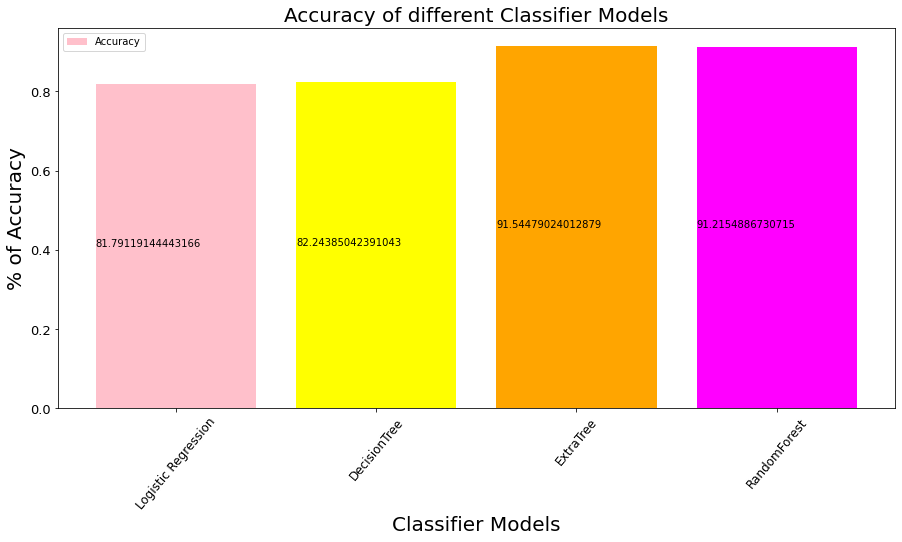

In [85]:
x_axis = acc_lables
y_axis = acc_list
colors = ['pink', 'yellow', 'orange', 'magenta']

# Create the plot
# setting figure size by using figure() function 
plt.figure(figsize = (15, 7))
      
bars = plt.bar(x_axis, y_axis, color=colors, label='Accuracy')
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy", fontsize = 20)
plt.title("Accuracy of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 50)
plt.yticks(fontsize = 13)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval/2, yval*100)
    
# Add the legend.
plt.legend()
plt.show()